In [1]:
import numpy as np
from scipy import linalg
import pandas as pd

In [2]:
# Read it in
path = "../data/surveys.xlsx"
survey_32W = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32W", converters={'T3':str})
survey_32N = pd.read_excel('Survey_32N and 32W consolidated.xlsx', sheet_name="Survey_32N")

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)
survey_32N.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]')]

# Select responses
res_together = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()

res_N = survey_32N['T5'].tolist()

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

In [4]:
embeddings = model.encode(res_together)

In [5]:
testing = embeddings

In [6]:
np.shape(testing)

(76, 768)

## Implementing DEIM

I did this implementation in two different functions to clearly split the tasks.  The DEIM function is the row selection process, and the CUR function is then execution of the actual factorization using the DEIM row selection method

In [209]:
def DEIM(V):
    #Modified Row Selection
    E = np.identity(len(V))
    Pcol = []
    p1 = np.argmax(abs(V[:,0]))
    Pcol.append(p1)
    
    for j in range(1, np.shape(V)[1]):
        Ei = np.array([E[i] for i in Pcol])
        Vi = np.transpose(np.array([V[:, i] for i in range(0, j)]))
        inv = linalg.inv(Ei @ Vi)
        P_i = Vi @ inv @ Ei
        ri = V[:, j] - P_i @ V[:, j]
        Pcol.append(np.argmax(abs(ri)))
        
    return Pcol

In [161]:
E = np.identity(76)
p = [3, 5, 1]
temp = np.array([E[i] for i in p])
np.shape(temp)

(3, 76)

In [192]:
six = np.array([[2]])

In [195]:
linalg.inv(six)

array([[0.5]])

In [97]:
def cur(A):
    #computing the SVD
    U, S, Vt = np.linalg.svd(A)
    rowID, colID = DEIM(U)
    C = np.array([A[i] for i in colID])
    R = np.array([A[i] for i in rowID])
    U = linalg.pinv(C) @ A @ linalg.pinv(R)
    return (C, U, np.transpose(R))

In [58]:
test = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]])

In [59]:
C, U, R = cur(test)

In [60]:
C

array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9]])

In [23]:
U

array([[-0.08080808, -0.11616162, -0.15151515, -0.15151515],
       [ 0.02525253,  0.00505051, -0.01515152, -0.01515152],
       [ 0.13131313,  0.12626263,  0.12121212,  0.12121212]])

In [24]:
R

array([[ 4,  7, 10, 10],
       [ 5,  8, 11, 11],
       [ 6,  9, 12, 12]])

In [199]:
U, S, Vt = linalg.svd(embeddings)

### For separate responses

In [36]:
embeddings2 = model.encode(res_separate)

In [215]:
U2, S2, Vt2 = linalg.svd(embeddings2)

In [216]:
idx2 = DEIM(U2)

In [40]:
most_important_same = pd.DataFrame({'Responses sorted from most to least important': [res_separate[i] for i in row]})

In [41]:
most_important_same.to_excel('most_important_separate_outfit.xlsx')

In [129]:
def select(Vt, axis, A): # Easier access to columns of V if we use V^T
    rank = np.linalg.matrix_rank(A)
    p = np.zeros(rank, dtype=int) # array of indices
    p[0] = np.argmax(np.abs(Vt[0])) # row index of the largest value in the first column of V
    for i in range(1,rank):
        v1 = Vt[i]
        v0 = Vt[i-1]
        res = v1 - (v1[p[i-1]]/v0[p[i-1]]) * v0
        p[i] = np.argmax(np.abs(res))
    return p

In [123]:
U, S, Vt = linalg.svd(embeddings)

In [214]:
important_together = [res_together[i] for i in idx]

In [218]:
important_separate = [res_separate[i] for i in idx2]

In [219]:
important_together_F = pd.DataFrame({'Ranked "Together" responses': important_together})
important_separate_f = pd.DataFrame({'Ranked "separate" responses': important_separate})

In [220]:
important_together_F.to_excel('together_ranked.xlsx')
important_separate_f.to_excel('separate_ranked.xlsx')

## A refresher on the singular values

### Together responses

In [222]:
import matplotlib.pyplot as plt

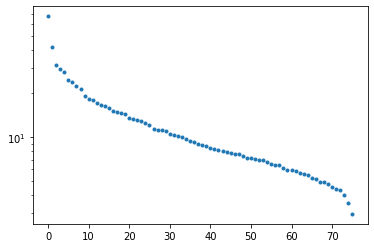

In [227]:
plt.semilogy(linalg.svd(embeddings)[1], '.')

### Separate Responses

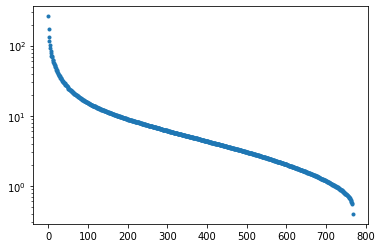

In [228]:
plt.semilogy(linalg.svd(embeddings2)[1], '.')